# **Decision Tree -- CHAID**
Predicting attrition in a fictional company.

In this application, we will use the CHAID method to analyse a dataset. We will explore the *Ionospere* dataset, available in the *mlbench* R package.

## Setting your R environment

In [ ]:
install.packages("partykit")
install.packages("CHAID", repos="http://R-Forge.R-project.org")

if (!require(rsample)) install.packages('rsample')
if (!require(dplyr)) install.packages('dplyr')
if (!require(dplyr)) install.packages('ggplot2')
if (!require(partykit)) install.packages('partykit')
if (!require(CHAID)) install.packages('CHAID')
if (!require(purrr)) install.packages('purrr')
if (!require(caret)) install.packages('caret')
if (!require(modeldata)) install.packages('modeldata')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: rsample

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: partykit

Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: CHAID

Loading required package: purrr

Loading required package: caret

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘caret’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘diagram’, ‘lava’, ‘prodlim’, ‘clock’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘fo

In [ ]:
library(rsample)
library(dplyr)
library(ggplot2)
library(partykit)
library(CHAID)
library(purrr)
library(caret)
library(modeldata)
theme_set(theme_bw()) # set theme

## Loading the attrition dataset and modify
We load the *attrition* dataset. The *attrition* variable gives us a 'yes' or 'no' answer to the question of whether or not the employee left.


In [ ]:
data("attrition", package = "modeldata")
names(attrition)
head(attrition)

In [ ]:
print(paste(c("nb rows", "nb cols"), dim(attrition)))
str(attrition)

The CHAID library requires that the predictors variables are either *factor* or *ordered factor*. We should have a look at the *int* and directly turn them into factor when the number of levels are less that 10. The other *int* variable should be discretized.<br>

Have look at *?CHAID::chaid*.

First, let's identify the *int* columns with less than 10 different values/levels.

In [ ]:
attrition %>%
  select_if(function(col)
    length(unique(col)) <= 10 & is.integer(col)) %>%
  head

These columns can reasonably be turned into factors.

In [ ]:
attrition <- mutate(attrition,
      JobLevel = factor(JobLevel),
      NumCompaniesWorked = factor(NumCompaniesWorked),
      StockOptionLevel = factor(StockOptionLevel),
      TrainingTimesLastYear = factor(TrainingTimesLastYear)
                    )
str(attrition)

In [ ]:
summary(attrition)

## Create a sub dataset with on factor variables

In [ ]:
newattrit <- attrition %>%
  select_if(is.factor)
dim(newattrit)

## Train a CHAID tree

In [ ]:
# demonstrate a full model using chaid with defaults
chaidattrit1 <- chaid(Attrition ~ ., data = newattrit)
print(chaidattrit1)

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 13, repr.plot.res = 200)

plot(
  chaidattrit1,
  main = "Testing Graphical Options",
  gp = gpar( fontsize = 8, lwd = 3  )
)

CHAID algorithm decides that the most predictive way to divide our sample of employees is into 20 terminal nodes or buckets. Note that, whatever the number of levels, the tree is **binary**.<br>

Also, notice that a variable can occur at different levels of the model like *StockOptionLevel* does.

## Control the final CHAID trees

CHAID proposes *chaid_control* to controls the model building. We can use the following criteria:

- *minsplit* Number of observations in splitted response at which no further split is desired.
- *minprob* Minimum frequency of observations in terminal nodes.
- *maxheight* Maximum height for the tree.

### minsplit and minprob

In [ ]:
ctrl <- chaid_control(minsplit = 200, minprob = 0.05)
ctrl # notice the rest of the list is there at the default value

$alpha2
[1] 0.05

$alpha3
[1] -1

$alpha4
[1] 0.05

$minsplit
[1] 200

$minbucket
[1] 7

$minprob
[1] 0.05

$stump
[1] FALSE

$maxheight
[1] -1

attr(,"class")
[1] "chaid_control"

In [ ]:
chaidattrit2 <- chaid(Attrition ~ ., data = newattrit,
                      control = ctrl)
print(chaidattrit2)


Model formula:
Attrition ~ BusinessTravel + Department + Education + EducationField + 
    EnvironmentSatisfaction + Gender + JobInvolvement + JobLevel + 
    JobRole + JobSatisfaction + MaritalStatus + NumCompaniesWorked + 
    OverTime + PerformanceRating + RelationshipSatisfaction + 
    StockOptionLevel + TrainingTimesLastYear + WorkLifeBalance

Fitted party:
[1] root
|   [2] OverTime in No
|   |   [3] StockOptionLevel in 0
|   |   |   [4] JobSatisfaction in Low: No (n = 84, err = 31.0%)
|   |   |   [5] JobSatisfaction in Medium, High
|   |   |   |   [6] JobInvolvement in Low: Yes (n = 12, err = 41.7%)
|   |   |   |   [7] JobInvolvement in Medium, High, Very_High
|   |   |   |   |   [8] BusinessTravel in Non-Travel, Travel_Rarely: No (n = 181, err = 9.9%)
|   |   |   |   |   [9] BusinessTravel in Travel_Frequently: No (n = 38, err = 28.9%)
|   |   |   [10] JobSatisfaction in Very_High: No (n = 134, err = 7.5%)
|   |   [11] StockOptionLevel in 1, 2, 3
|   |   |   [12] EnvironmentSa

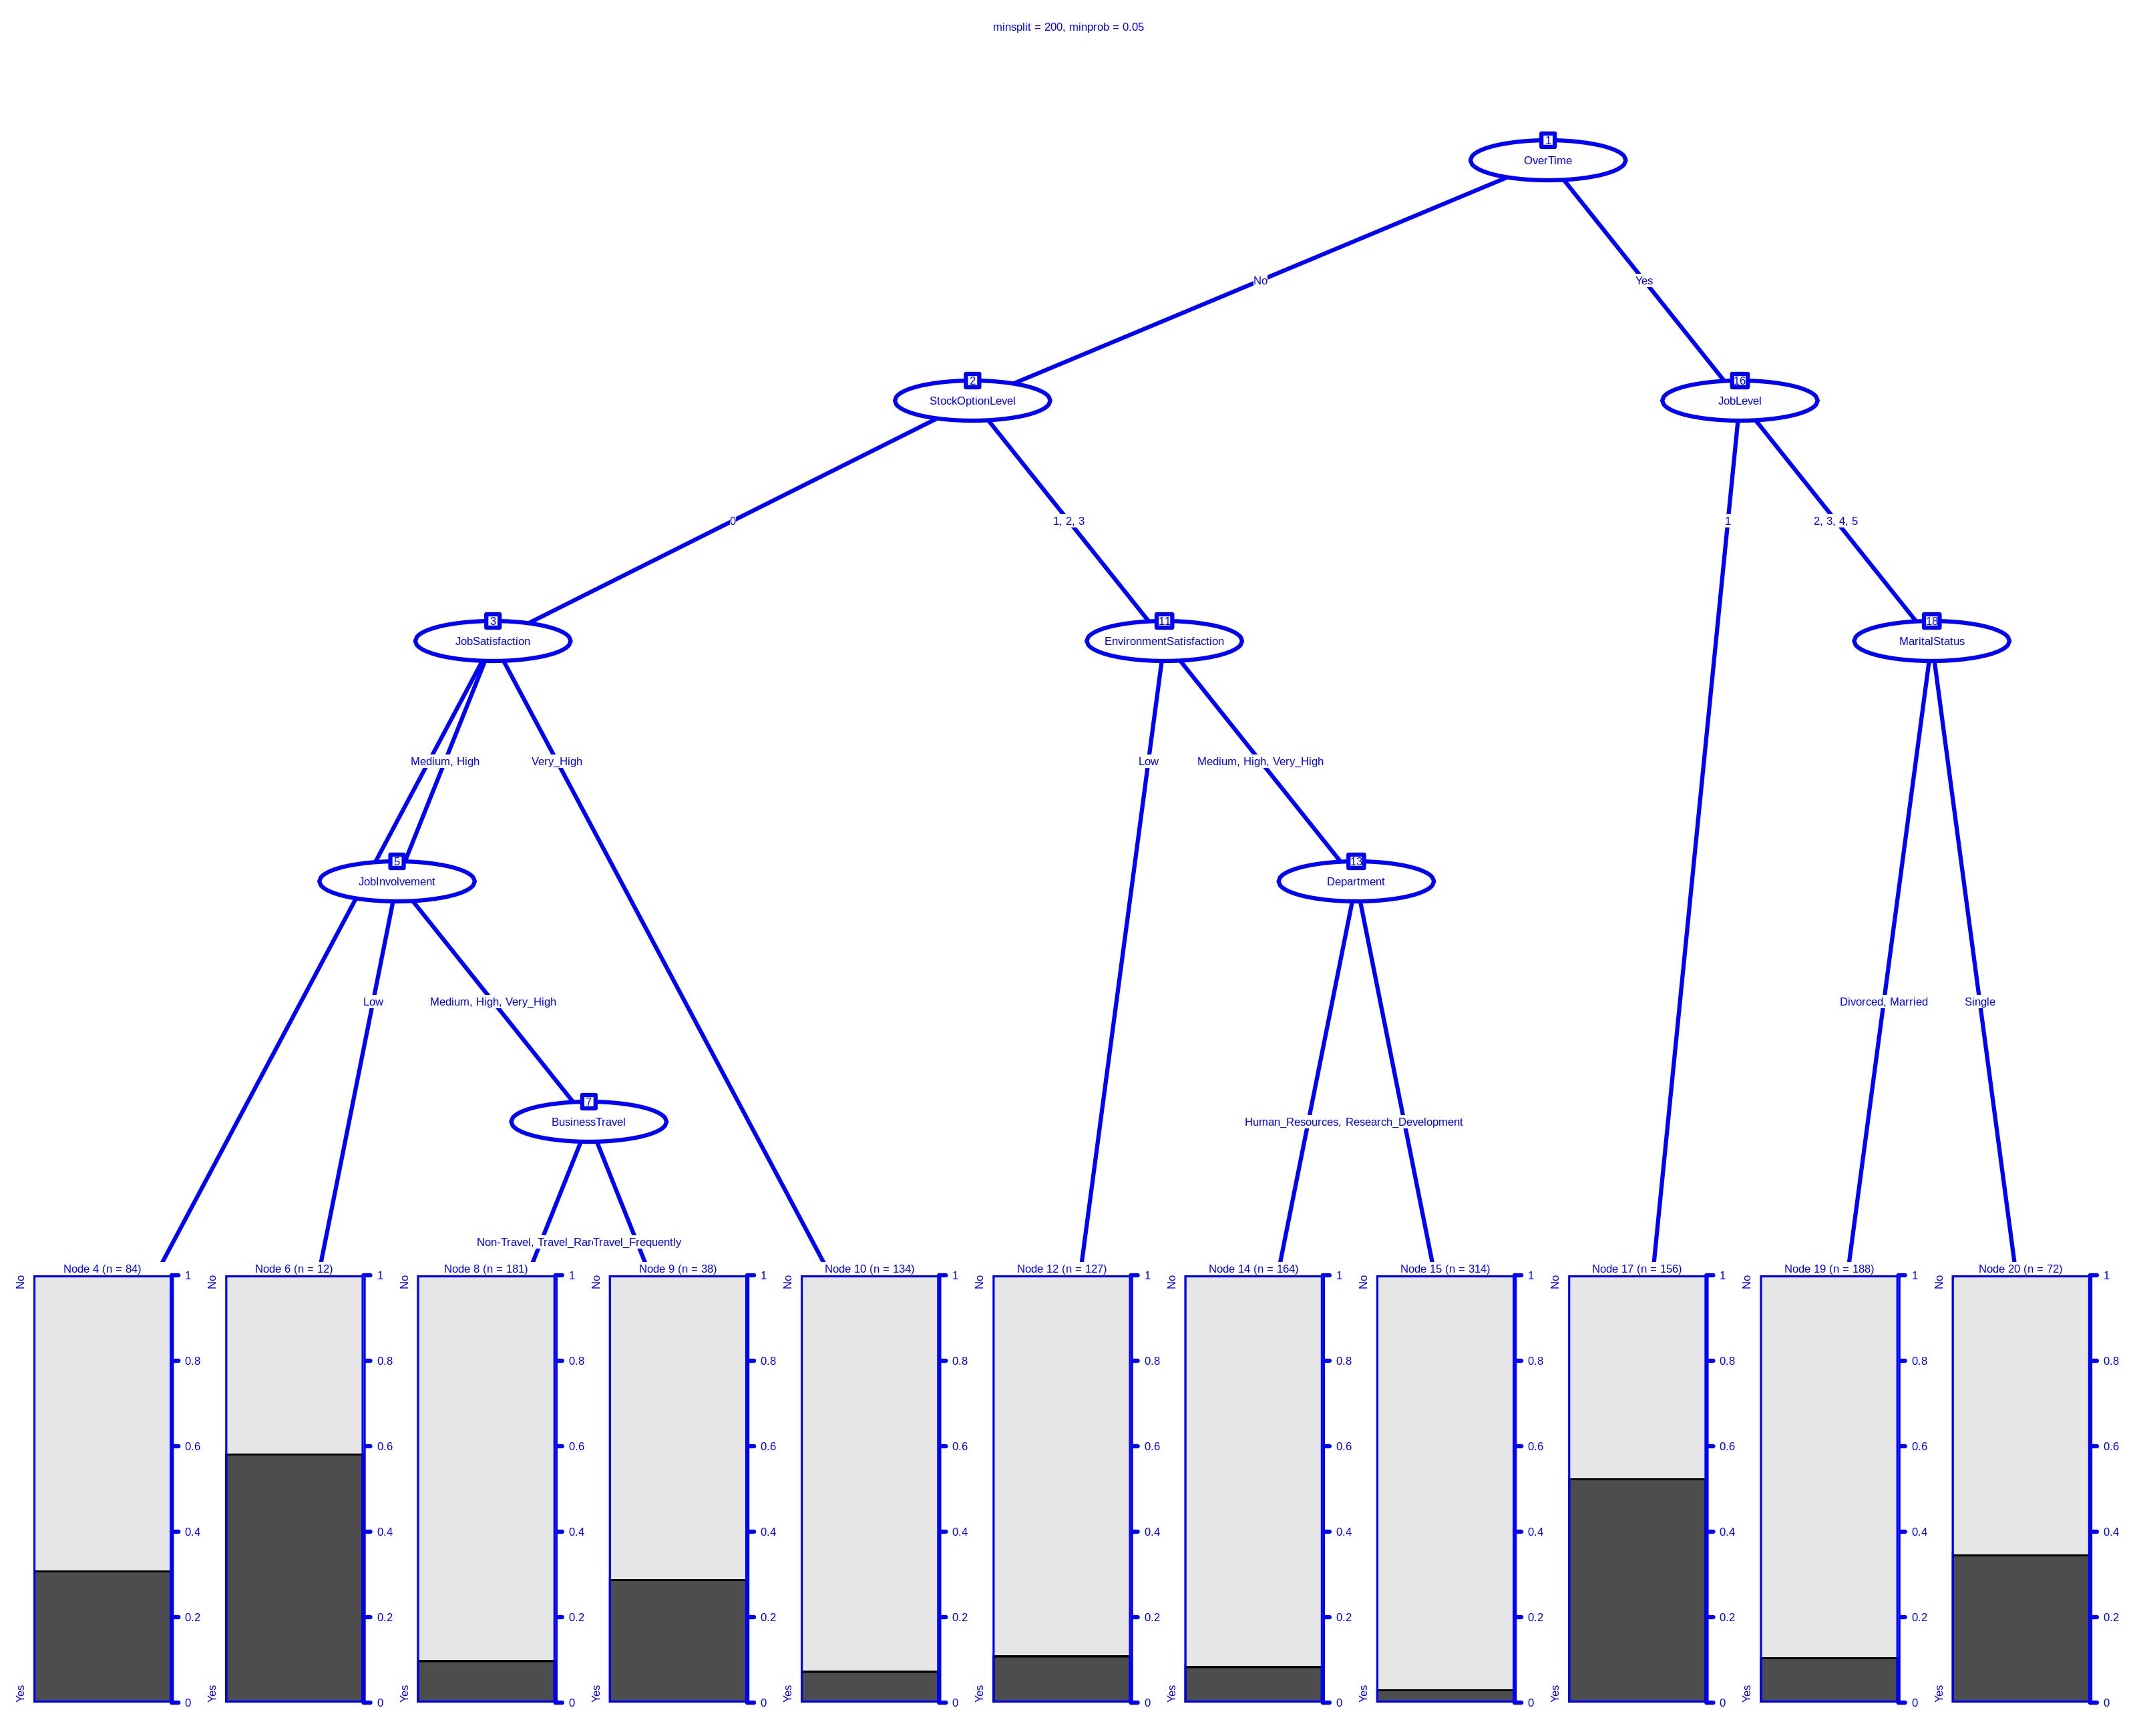

In [ ]:
plot(
  chaidattrit2,
  main = "minsplit = 200, minprob = 0.05",
  gp = gpar( fontsize = 6, col = "blue", lty = "solid",
    lwd = 3  )
)

### maxheight

In [ ]:
ctrl <- chaid_control(maxheight = 3)
chaidattrit3 <- chaid(Attrition ~ ., data = newattrit, control = ctrl)
print(chaidattrit3)


Model formula:
Attrition ~ BusinessTravel + Department + Education + EducationField + 
    EnvironmentSatisfaction + Gender + JobInvolvement + JobLevel + 
    JobRole + JobSatisfaction + MaritalStatus + NumCompaniesWorked + 
    OverTime + PerformanceRating + RelationshipSatisfaction + 
    StockOptionLevel + TrainingTimesLastYear + WorkLifeBalance

Fitted party:
[1] root
|   [2] OverTime in No
|   |   [3] StockOptionLevel in 0
|   |   |   [4] JobSatisfaction in Low: No (n = 84, err = 31.0%)
|   |   |   [5] JobSatisfaction in Medium, High: No (n = 231, err = 15.6%)
|   |   |   [6] JobSatisfaction in Very_High: No (n = 134, err = 7.5%)
|   |   [7] StockOptionLevel in 1, 2, 3
|   |   |   [8] EnvironmentSatisfaction in Low: No (n = 127, err = 11.0%)
|   |   |   [9] EnvironmentSatisfaction in Medium, High, Very_High: No (n = 478, err = 5.0%)
|   [10] OverTime in Yes
|   |   [11] JobLevel in 1
|   |   |   [12] StockOptionLevel in 0, 3: Yes (n = 89, err = 34.8%)
|   |   |   [13] StockOption

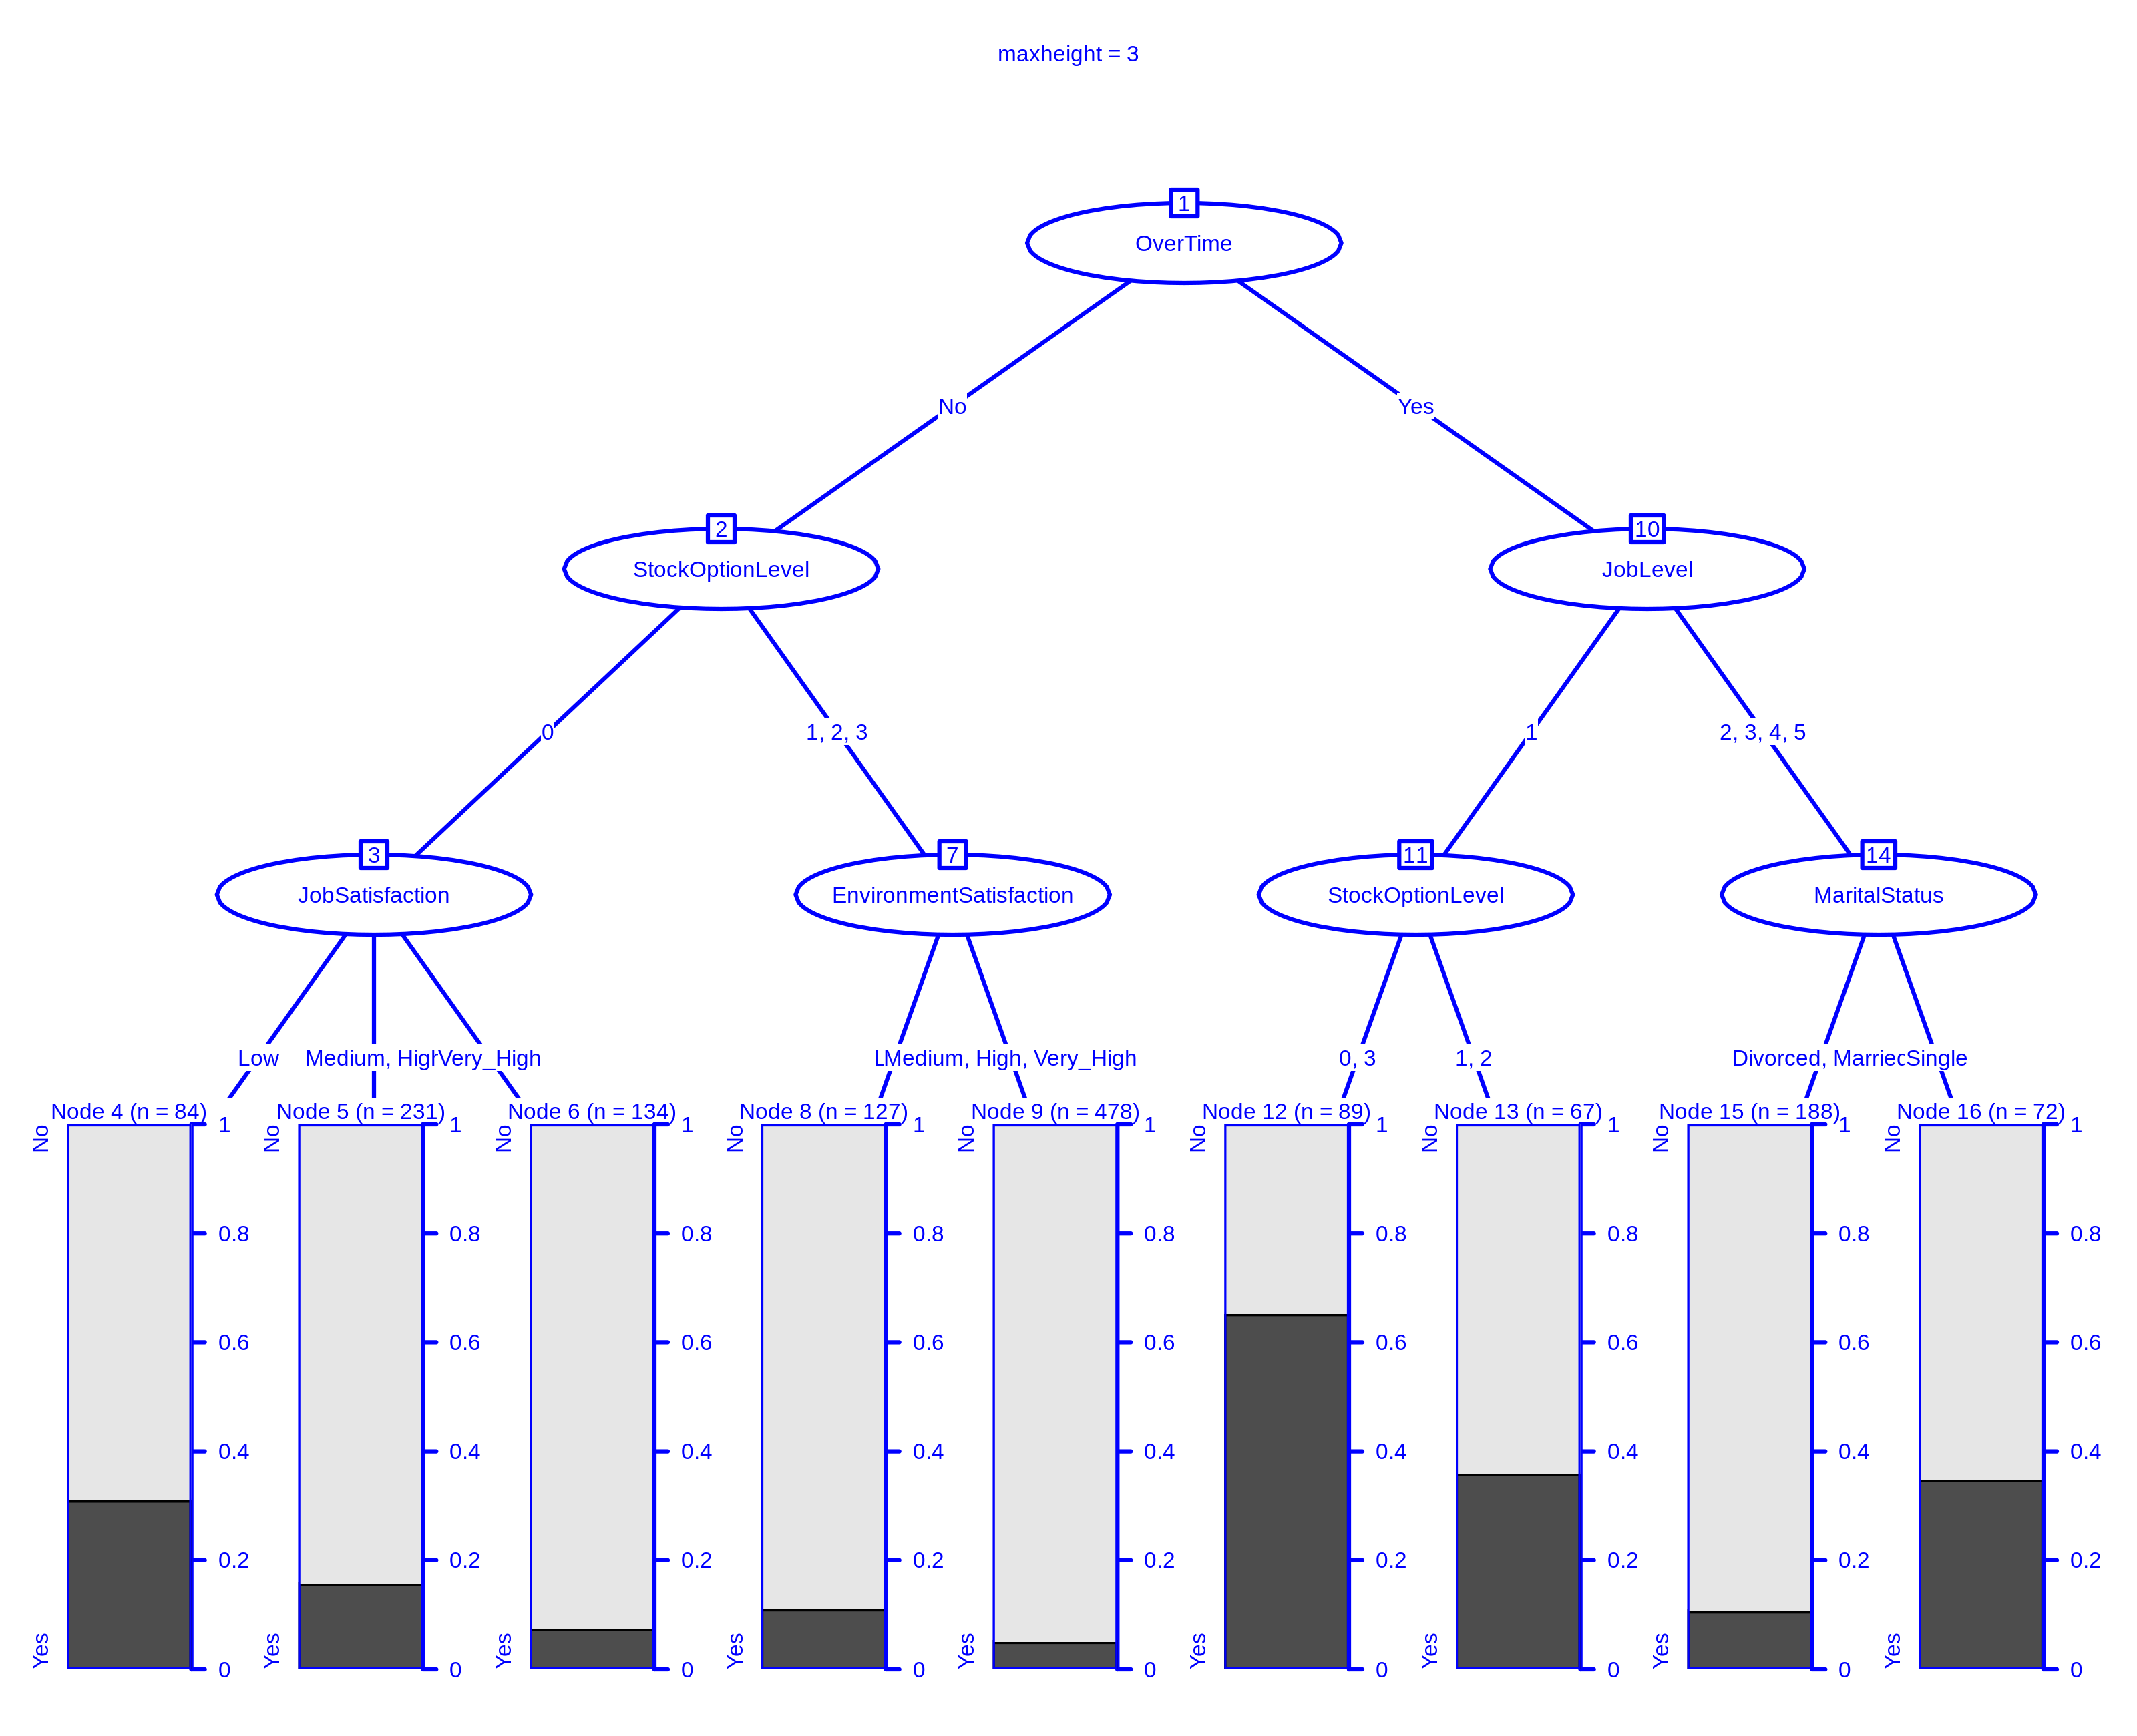

In [ ]:
plot(
  chaidattrit3,
  main = "maxheight = 3",
  gp = gpar(
    col = "blue",
    lty = "solid",
    lwd = 3  )
)

### A last control on the significance level...
- **alpha2** Level of significance used for merging of predictor categories.
- **alpha4** Level of significance used for splitting of a node in the most significant predictor

In [ ]:
ctrl <- chaid_control(alpha2 = .01, alpha4 = .01)
chaidattrit4 <- chaid(Attrition ~ ., data = newattrit, control = ctrl)
print(chaidattrit4)


Model formula:
Attrition ~ BusinessTravel + Department + Education + EducationField + 
    EnvironmentSatisfaction + Gender + JobInvolvement + JobLevel + 
    JobRole + JobSatisfaction + MaritalStatus + NumCompaniesWorked + 
    OverTime + PerformanceRating + RelationshipSatisfaction + 
    StockOptionLevel + TrainingTimesLastYear + WorkLifeBalance

Fitted party:
[1] root
|   [2] OverTime in No
|   |   [3] StockOptionLevel in 0
|   |   |   [4] JobSatisfaction in Low
|   |   |   |   [5] RelationshipSatisfaction in Low, Medium, High: No (n = 56, err = 42.9%)
|   |   |   |   [6] RelationshipSatisfaction in Very_High: No (n = 28, err = 7.1%)
|   |   |   [7] JobSatisfaction in Medium, High, Very_High
|   |   |   |   [8] JobInvolvement in Low: No (n = 20, err = 45.0%)
|   |   |   |   [9] JobInvolvement in Medium, High, Very_High
|   |   |   |   |   [10] JobLevel in 1: No (n = 139, err = 18.0%)
|   |   |   |   |   [11] JobLevel in 2, 3, 4, 5: No (n = 206, err = 5.8%)
|   |   [12] StockOption

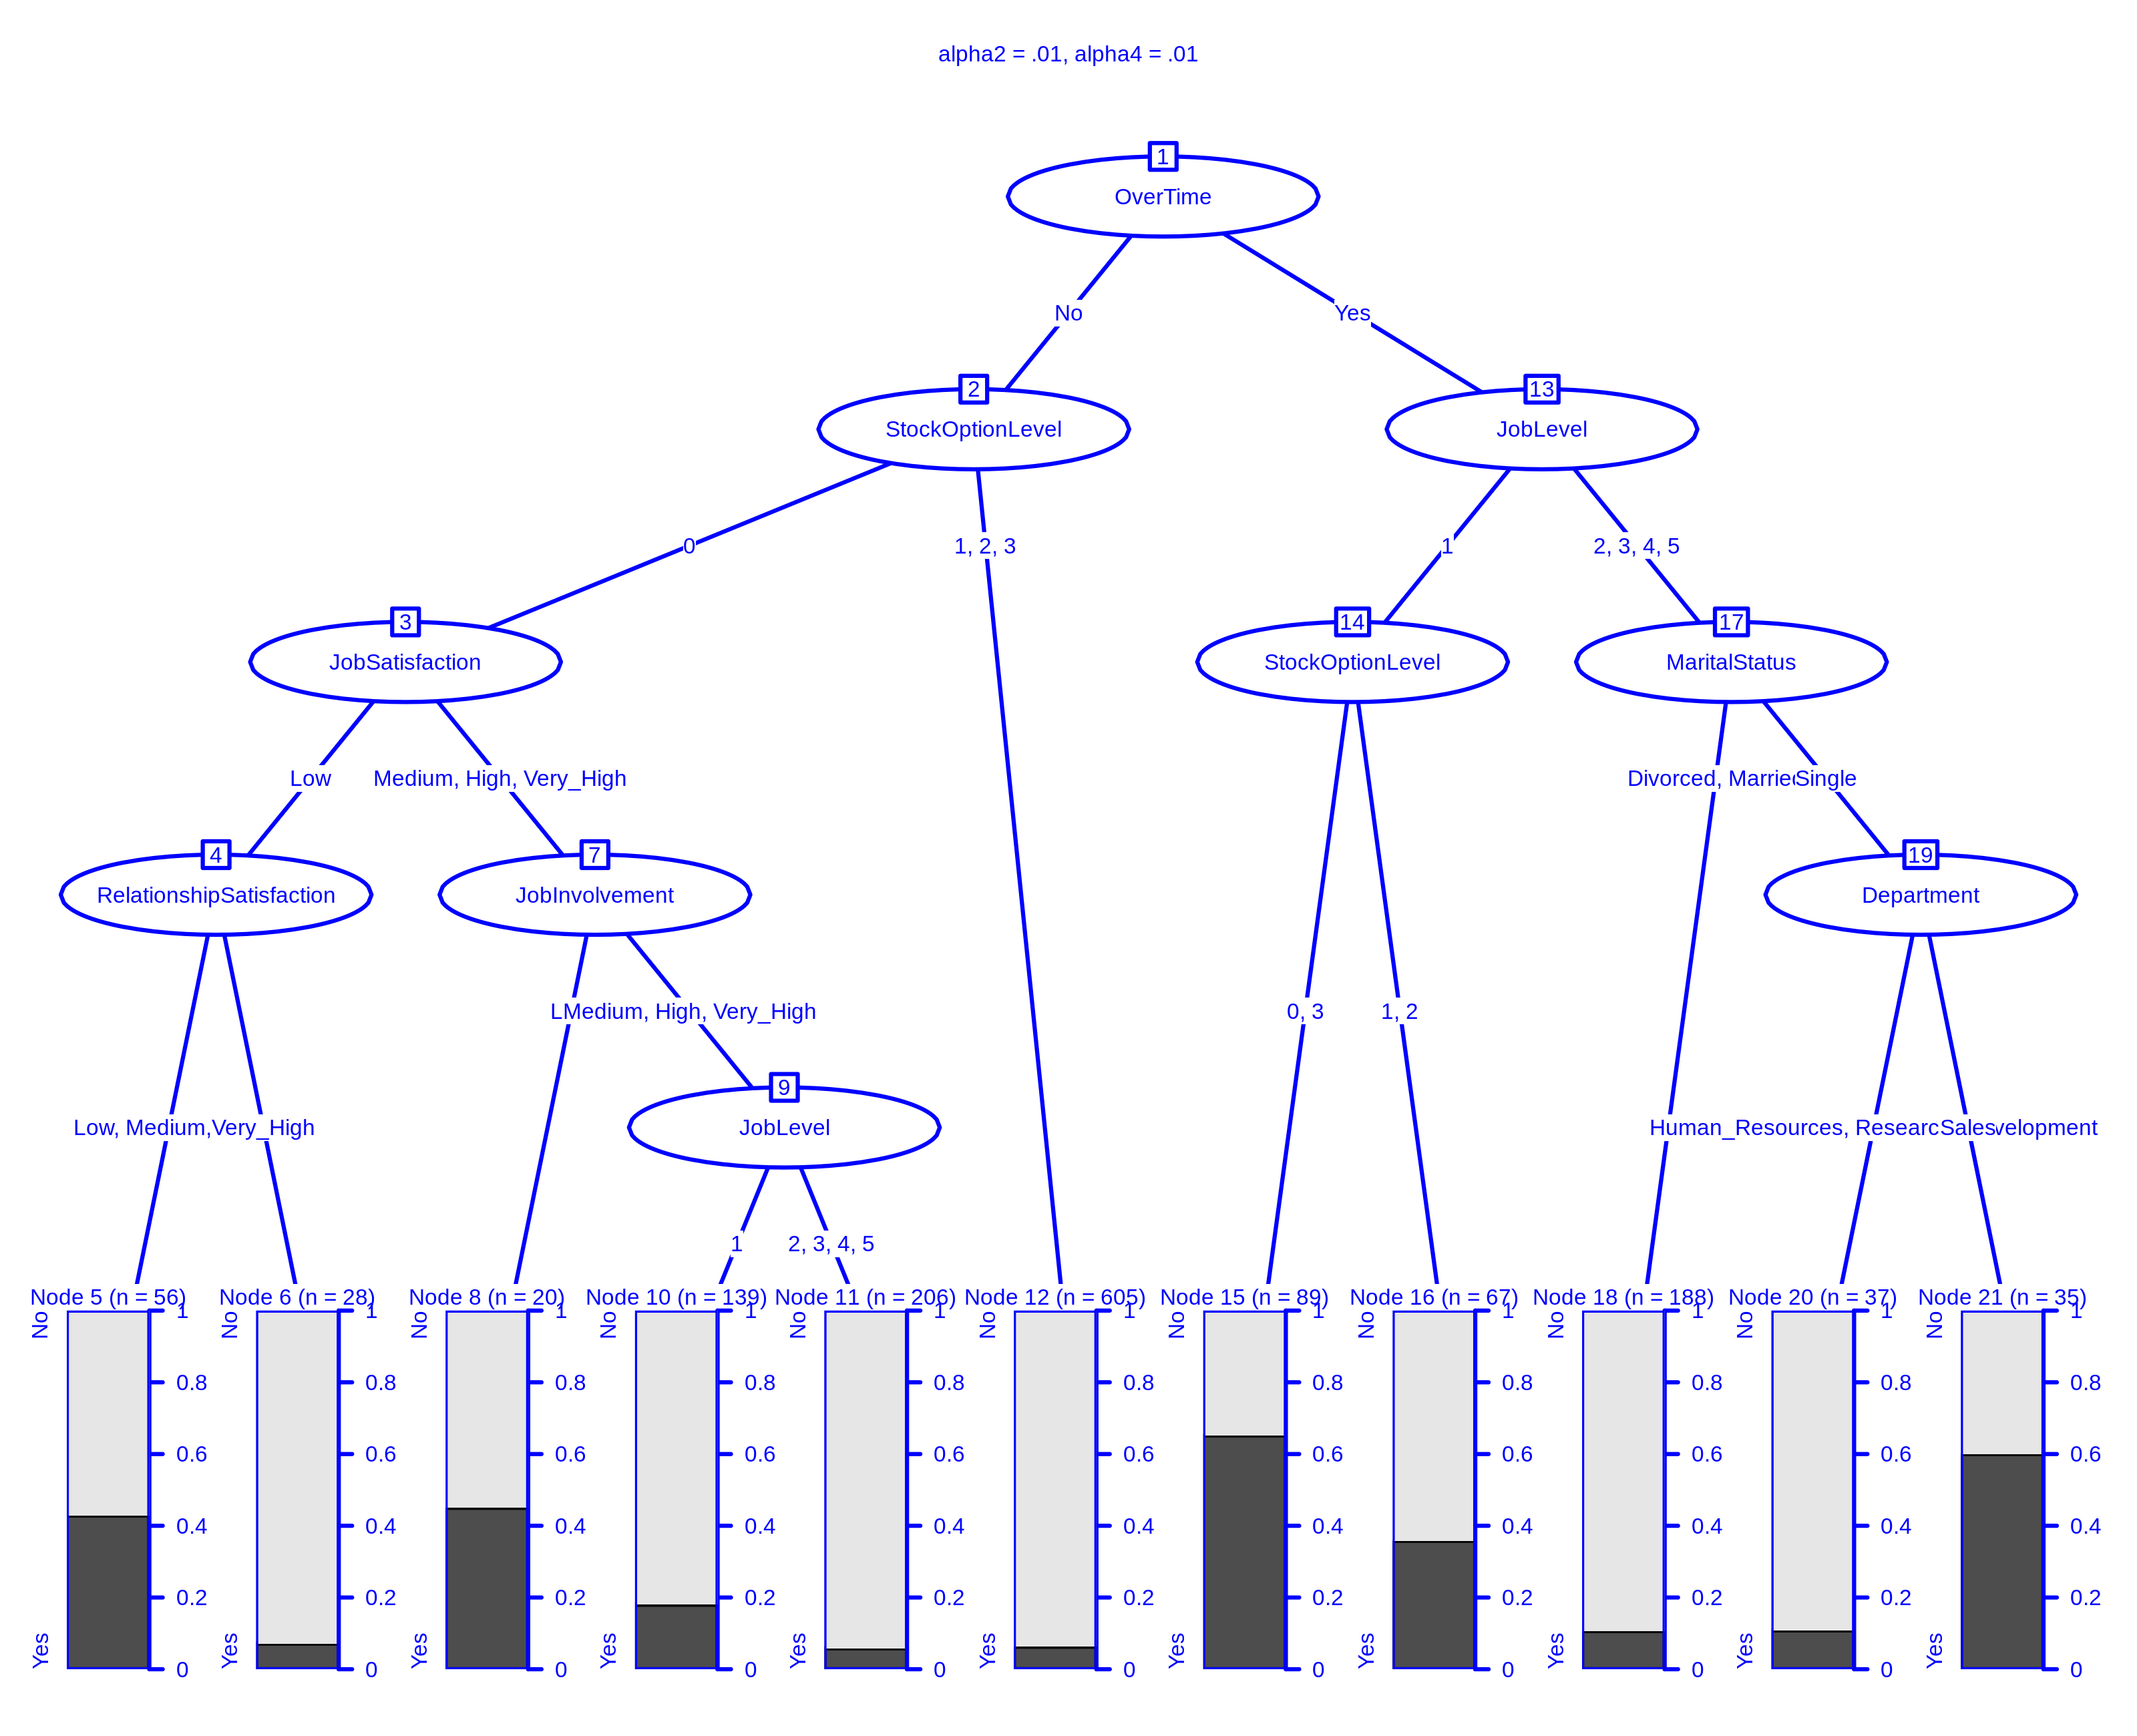

In [ ]:
plot(
  chaidattrit4,
  main = "alpha2 = .01, alpha4 = .01",
  gp = gpar(
    col = "blue",
    lty = "solid",
    lwd = 3  )
)

## Which model should I choose?

### Make the prediction with the 4 models

In [ ]:
pmodel1 <- predict(chaidattrit1)
print(head(pmodel1))
print(head(newattrit$Attrition))

 34  19  23  23  16  14 
Yes  No Yes Yes  No  No 
Levels: No Yes
[1] Yes No  Yes No  No  No 
Levels: No Yes


In [ ]:
pmodel2 <- predict(chaidattrit2)
pmodel3 <- predict(chaidattrit3)
pmodel4 <- predict(chaidattrit4)

In [ ]:
confusionMatrix(pmodel1, newattrit$Attrition)
confusionMatrix(pmodel2, newattrit$Attrition)
confusionMatrix(pmodel3, newattrit$Attrition)
confusionMatrix(pmodel4, newattrit$Attrition)

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1190  147
       Yes   43   90
                                          
               Accuracy : 0.8707          
                 95% CI : (0.8525, 0.8875)
    No Information Rate : 0.8388          
    P-Value [Acc > NIR] : 0.0003553       
                                          
                  Kappa : 0.4192          
                                          
 Mcnemar's Test P-Value : 7.874e-14       
                                          
            Sensitivity : 0.9651          
            Specificity : 0.3797          
         Pos Pred Value : 0.8901          
         Neg Pred Value : 0.6767          
             Prevalence : 0.8388          
         Detection Rate : 0.8095          
   Detection Prevalence : 0.9095          
      Balanced Accuracy : 0.6724          
                                          
       'Positive' Class : No              
                        

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1154  148
       Yes   79   89
                                          
               Accuracy : 0.8456          
                 95% CI : (0.8261, 0.8637)
    No Information Rate : 0.8388          
    P-Value [Acc > NIR] : 0.2516          
                                          
                  Kappa : 0.353           
                                          
 Mcnemar's Test P-Value : 6.382e-06       
                                          
            Sensitivity : 0.9359          
            Specificity : 0.3755          
         Pos Pred Value : 0.8863          
         Neg Pred Value : 0.5298          
             Prevalence : 0.8388          
         Detection Rate : 0.7850          
   Detection Prevalence : 0.8857          
      Balanced Accuracy : 0.6557          
                                          
       'Positive' Class : No              
                        

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1202  179
       Yes   31   58
                                          
               Accuracy : 0.8571          
                 95% CI : (0.8382, 0.8746)
    No Information Rate : 0.8388          
    P-Value [Acc > NIR] : 0.02864         
                                          
                  Kappa : 0.2936          
                                          
 Mcnemar's Test P-Value : < 2e-16         
                                          
            Sensitivity : 0.9749          
            Specificity : 0.2447          
         Pos Pred Value : 0.8704          
         Neg Pred Value : 0.6517          
             Prevalence : 0.8388          
         Detection Rate : 0.8177          
   Detection Prevalence : 0.9395          
      Balanced Accuracy : 0.6098          
                                          
       'Positive' Class : No              
                        

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1188  158
       Yes   45   79
                                          
               Accuracy : 0.8619          
                 95% CI : (0.8432, 0.8791)
    No Information Rate : 0.8388          
    P-Value [Acc > NIR] : 0.007845        
                                          
                  Kappa : 0.3676          
                                          
 Mcnemar's Test P-Value : 3.815e-15       
                                          
            Sensitivity : 0.9635          
            Specificity : 0.3333          
         Pos Pred Value : 0.8826          
         Neg Pred Value : 0.6371          
             Prevalence : 0.8388          
         Detection Rate : 0.8082          
   Detection Prevalence : 0.9156          
      Balanced Accuracy : 0.6484          
                                          
       'Positive' Class : No              
                        